<h1><center> Natural Language Processing with Disaster Tweets </center></h1>


## Description of Project

This project uses natural language processing techniques to analyze tweet data and classify tweets as related to real-world disasters or not. The aim is to automate the detection of disaster-related communications, which are crucial during emergency response situations.

## Required Datasets

**Disaster Tweets Dataset**:

This project utilizes two primary datasets, `train.csv` and `test.csv`, which should be downloaded and stored in a `data` directory accessible by the notebook.

### How to Download Dataset
To access and set up the datasets, please follow these steps:

1. Create a `data` folder in your project directory if it doesn't already exist.
2. Download the `train.csv` and `test.csv` files from the following Kaggle competition link:
   - [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/data) 
   - you will need to agree to the terms of the dataset
3. Place the downloaded `train.csv` and `test.csv` files into the `data` folder. This step ensures that all data files are ready to be accessed by the notebook.

### Additional JSON Resources
Alongside the main datasets, the project utilizes two JSON files for text preprocessing. Ensure these files are also placed in the `data` directory:
- **`english_contractions_lowercase.json`**: Contains mappings for English contractions to their expanded forms, crucial for normalizing the text data.
- **`english_acronyms_lowercase.json`**: Provides mappings for common English acronyms to their full forms, assisting in clarifying the text content.

### File Descriptions
- **train.csv**: Contains the tweets and labels for training your model. Each row in this file corresponds to a tweet, and includes the text of the tweet along with a binary label indicating whether the tweet is about a real disaster (1) or not (0).
- **test.csv**: Contains the tweets for which you will predict the disaster relevance. This file includes only the text of the tweets without any labels.

### Setup for Dataset Use
After placing the files in the `data` directory, ensure your Jupyter notebook is configured to read from this directory. This might involve setting the correct path to the `data` folder in your data loading script or notebook cells.


## Contents of the Notebook

- **Introduction**: Overview of the project's aim and importance.
- **Basic Exploratory Data Analysis**: Initial analysis of the data to understand the distribution and nature of the dataset.
- **Text Normalization**: Processing steps to clean and normalize the text data.
- **Bag of N-grams Model**: Implementation of a Bag of N-grams model to predict disaster relevance.
- **TF-IDF Model**: Utilization of TF-IDF scores for feature extraction and model training.
- **Acknowledgements**: Credits to data providers and contributors.
- **References**: Sources and inspirations for the project methodology.

## Expected Packages and Resource Requirements

**Python Packages**:
- numpy
- pandas
- scikit-learn
- nltk
- xgboost
- seaborn
- wordcloud

## Install Required Packages

   - To enhance the functionality of the CTPO environment, you may need to install some libraries not pre-installed but required for this notebook. Follow these steps to install the necessary libraries from the `requirements.txt` file:

   **Create and Activate the Virtual Environment:**
   
   Open your terminal or command prompt within the jupyter notebook. `File -> New -> Terminal`
   
   Navigate to the project directory where you want to set up the environment.
   
   Execute the following commands in a `bash` to create and activate the virtual environment:
   
   ```
   python3 -m venv --system-site-packages myvenv #myvenv is name of virtual environment you can change it
   source myvenv/bin/activate
   pip3 install ipykernel
   python -m ipykernel install --user --name=myvenv --display-name="Python (myvenv)"
   ```
   **Install Required Libraries**
   
   Before running the following command in jupyter notebook, make sure you are in the directory where the Jupyter Notebook and virtual environment is located. This ensures the ./ path is always current. You can use the cd command to change to your project directory and pwd to verify your current directory.
   
   ```
   !. ./myvenv/bin/activate; pip install -r requirements.txt
   ```
### Important Note

It is crucial to load the new "myvenv" kernel for the notebook to work correctly. If the new "myvenv" kernel is not loaded, the required libraries and environment settings will not be applied, and the notebook will not function as expected.


In [ ]:
!. ./myvenv/bin/activate; pip install -r requirements.txt

In [ ]:
# Importing necessary libraries
import time, os, psutil, random, operator, gc
from IPython.display import display, HTML
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

import json
import subprocess
import sys
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

import string
import re
from string import punctuation
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, WordPunctTokenizer, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from num2words import num2words
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
# Specify the path to your NLTK data directory within the virtual environment
nltk_data_dir = './myvenv/nltk_data'
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)

# Function to check and download necessary NLTK resources
def download_nltk_resources():
    resources = {
        'corpora/stopwords': 'stopwords',
        'taggers/averaged_perceptron_tagger': 'averaged_perceptron_tagger'
    }
    
    for resource_path, resource_name in resources.items():
        try:
            # Check if the resource is available
            nltk.data.find(resource_path)
            print(f"NLTK resource '{resource_name}' is already installed.")
        except LookupError:
            # If not present, download the resource to the specified directory
            nltk.download(resource_name, download_dir=nltk_data_dir)
            print(f"NLTK resource '{resource_name}' downloaded successfully.")

# Call the function to ensure resources are downloaded
download_nltk_resources()

NLTK resource 'stopwords' is already installed.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./myvenv/nltk_data...


NLTK resource 'averaged_perceptron_tagger' downloaded successfully.


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
# Recording the start time
start = time.time()

In [5]:
# Setting random seeds
os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
np.random.seed(0)

# Introduction

## Data

**Source:** **https://www.kaggle.com/c/nlp-getting-started/data**

The training dataset contains information on $7613$ tweets, each with a unique id, keyword (if available), location (if available), text and whether or not the tweet indicates a real disaster or not (expressed via a binary variable). The test dataset contains information on $3263$ tweets with the same features as above except the status of real disaster, which is to be predicted. The features of the dataset are described below.

**id** : A unique identifier corresponding to the tweet

**keyword** : A highlighting word from the tweet

**location** : The location from where the tweet is sent

**text**: The textual content of the tweet

**target** : A binary variable, which is $0$ if the tweet does not indicate a real disaster and $1$ if it does

Note that the features **keyword** and **location** may be blank for many tweets.

In [6]:
# The dataset
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')

In [7]:
print('The training set contains information on {} tweets.'.format(len(data_train)))
data_train[['id', 'text', 'target']]

The training set contains information on 7613 tweets.


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [8]:
print('The test set contains information on {} tweets.'.format(len(data_test)))
data_test_target = data_test.copy()
data_test_target['target'] = '?'
data_test_target[['id', 'text', 'target']]

The test set contains information on 3263 tweets.


,id,text,target
0,0,Just happened a terrible car crash,?
1,2,"Heard about #earthquake is different cities, s...",?
2,3,"there is a forest fire at spot pond, geese are...",?
3,9,Apocalypse lighting. #Spokane #wildfires,?
4,11,Typhoon Soudelor kills 28 in China and Taiwan,?
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,?
3259,10865,Storm in RI worse than last hurricane. My city...,?
3260,10868,Green Line derailment in Chicago http://t.co/U...,?
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,?


## Project Objective

**The objective of the project is to predict whether a particular tweet, of which the text (occasionally the keyword and the location as well) is provided, indicates a real disaster or not.**

Twitter is one of the most active social media platform that many people use to share occurance of incidents including disasters. For example, if a fire breaks out in a building, many people around the particular location are likely to tweet about the incident. These tweets can send early alerts not only to people in the neighbourhood to evacuate, but also to the appropriate authority to take measures to minimize the loss, potentially saving lives. Thus the tweets indicating real disasters can be utilized for emergency disaster management to remarkable effect.

## Evaluation Metric

Too much false positives, where a model detects disaster in a tweet that does not indicate any such occurance, may be counterproductive and wasteful in terms of resources. Again, a false negative, where the model fails to detect a disaster from a tweet which actually indicates one, would delay disaster management and clearly costs too much. Observe that, in this problem, the class of tweets that indicate actual disasters (positive class) is more important than the class of tweets not indicating any disaster (negative class). Thus **the goal is to build a model that attempts to minimize the proportion of false positives in the predicted positive class (precision) and that of false negatives in the actual positive class (recall), assigning equal emphasis on both.** Let us denote

**TP**: Number of true positives

**TN**: Number of true negatives

**FP**: Number of false positives

**FN**: Number of false negatives

**Precision** and **Recall** are universally accepted metrics to capture the performance of a model, when restricted respectively to the **predicted positive class** and the **actual positive class**. These are defined as

$$\text{Precision} = \frac{TP}{TP + FP}.$$

$$\text{Recall} = \frac{TP}{TP + FN}.$$

The **F1-score** provides a balanced measuring stick by considering the *harmonic mean* of the above two matrices.

$$F_1\text{-Score} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}.$$

For its equal emphasis on both *precision* and *recall*, *F1-score* is one of the most suitable metrics for evaluating the models in this project.

## Classifiers

Next we list the classifiers, along with their specific hyperparameters, that are used in the notebook.

In [9]:
logreg = LogisticRegression(penalty = 'l2', dual = False, tol = 0.0001, C = 1.0, fit_intercept = False, intercept_scaling = 1, class_weight = 'balanced', random_state = 0, solver = 'saga', max_iter = 1000, multi_class = 'auto', verbose = 0, warm_start = False, n_jobs = -1, l1_ratio = None)

knn = KNeighborsClassifier(n_neighbors = math.floor(math.sqrt(len(data_train))), weights = 'uniform', algorithm = 'auto', leaf_size = 30, p = 2, metric = 'minkowski', metric_params = None, n_jobs = -1)

dt = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = None, min_samples_split = 4, min_samples_leaf = 1, min_weight_fraction_leaf = 0.0, max_features = None, random_state = 0, max_leaf_nodes = None, min_impurity_decrease = 0.0, class_weight = None, ccp_alpha = 0.0)

svm_linear = svm.SVC(C = 2.0, kernel = 'linear', degree = 3, gamma = 'scale', coef0 = 0.0, shrinking = True, probability = False, tol = 0.0001, cache_size = 200, class_weight = 'balanced', verbose = False, max_iter = -1, decision_function_shape = 'ovr', break_ties = False, random_state = 0)

svm_rbf = svm.SVC(C = 2.0, kernel = 'rbf', degree = 3, gamma = 'scale', coef0 = 0.0, shrinking = True, probability = False, tol = 0.0001, cache_size = 200, class_weight = 'balanced', verbose = False, max_iter = -1, decision_function_shape = 'ovr', break_ties = False, random_state = 0)

nb = GaussianNB()

rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 10, min_samples_split = 10, min_samples_leaf = 5, min_weight_fraction_leaf = 0.0, max_features = 'sqrt', max_leaf_nodes = None, min_impurity_decrease = 0.0, bootstrap = True, oob_score = False, n_jobs = -1, random_state = 0, verbose = 0, warm_start = False, class_weight = 'balanced', ccp_alpha = 0.0, max_samples = None)

lda = LinearDiscriminantAnalysis(solver = 'svd', shrinkage = None, priors = None, n_components = None, store_covariance = False, tol = 0.0001)

sgd = SGDClassifier(loss = 'log_loss', penalty = 'l2', alpha = 0.0001, l1_ratio = 0.15, fit_intercept = True, max_iter = 1000, tol = 0.001, shuffle = True, verbose = 0, epsilon = 0.1, n_jobs = -1, random_state = 0, learning_rate = 'optimal', eta0 = 0.0, power_t = 0.5, early_stopping = False, validation_fraction = 0.1, n_iter_no_change = 5, class_weight = None, warm_start = False, average = False) # loss = 'hinge'

ridge = RidgeClassifier(alpha = 2.0, fit_intercept = True, copy_X = True, max_iter = None, tol = 0.001, class_weight = 'balanced', solver = 'auto', random_state = 0)

xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', max_depth = 3, learning_rate = 0.3, n_estimators = 100, base_score = 0.5, random_state = 0, objective = 'binary:logistic', booster = 'gbtree', n_jobs = -1, nthread = None, gamma = 0, min_child_weight = 1, max_delta_step = 0, subsample = 1, colsample_bytree = 1, colsample_bylevel = 1, reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, seed = None) #, silent = True

ada = AdaBoostClassifier(n_estimators = 100, learning_rate = 1.0, algorithm = 'SAMME.R', random_state = 0) # base_estimator = None

In [10]:
clf_list = [logreg, knn, dt, svm_linear, svm_rbf, rf, sgd, ridge, xgb, ada] # nb, lda
clf_names = ["Logistic Regression", "KNN Classifier", "Decision Tree", "SVM (linear kernel)", "SVM (RBF kernel)", "Random Forest", "Stochastic Gradient Descent", "Ridge Classifier", "XGBoost Classifier", "AdaBoost Classifier"] # "Naive Bayes", "Linear Discriminant Analysis"

In [11]:
# Some Useful Functions

# Function to create a list of unique elements of a given list (in order of first appearance)
def unique(lst):
    list_unique = []
    for x in lst:
        if x not in list_unique:
            list_unique.append(x)
    return list_unique

# Function to convert float nan values to string
def nan_type_conv(lst):
    for i in range(len(lst)):
        if str(lst[i]) == 'nan':
            lst[i] = 'NaN'
            
# Word finder - Finding out if a specific word exists in a given list of words
def word_finder(word, lst):
    count = 0
    for x in lst:
        if x == word:
            count += 1
            break
    if count == 0:
        return False
    else:
        return True

# Word counter basic - Counting a specific word in a given list of words
def word_counter(word, lst):
    lst_word = [x for x in lst if x == word]
    return len(lst_word)

# Word counter dictionary - Creating a dictionary of unique words in a given list with their frequencies
def word_counter_dict(word_list):
    counter_dict = {}
    for word in word_list:
        if word not in counter_dict.keys():
            counter_dict[word] = 1
        else:
            counter_dict[word] += 1
    
    counter_dict_sorted = dict(sorted(counter_dict.items(), key = operator.itemgetter(1), reverse = True))
    return counter_dict_sorted

# Word counter dictionary - Creating a dictionary of unique words in a given list with their relative frequencies
def word_counter_dict_relative(word_list):
    counter_dict = {}
    for word in word_list:
        if word not in counter_dict.keys():
            counter_dict[word] = 1/len(word_list)
        else:
            counter_dict[word] += 1/len(word_list)
    
    counter_dict_sorted = dict(sorted(counter_dict.items(), key = operator.itemgetter(1), reverse = True))
    return counter_dict_sorted

# Function to convert a given dictionary into a dataframe with given column names
def dict_to_df(dictionary, C1, C2):
    df = pd.DataFrame(dictionary.items(), columns=[C1, C2])
    return df

# Word counter dataframe - Creating a dataframe of unique words in a given list with their frequencies
def word_counter_df(word_list):
    return dict_to_df(word_counter_dict(word_list), "Word", "Frequency")

# Word counter dataframe - Creating a dataframe of unique words in a given list with their relative frequencies
def word_counter_df_relative(word_list):
    return dict_to_df(word_counter_dict_relative(word_list), "Word", "Relative Frequency")

# Function to convert a given list of pairs into a dictionary
def list_to_dict(lst):
    dct = {lst[i][0]: lst[i][1] for i in range(len(lst))}
    return dct

# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

# List of punctuations except the apostrophe
punctuation_list = [w for w in punctuation if w not in ["'"]]

# Function to compute list of punctuations that are present in a given text
def text_punct(text):
    x = word_tokenize(text)
    punct_list = [w for w in x if w in punctuation_list]
    return punct_list

# Function to compute list of words that are present in a given list of texts
def text_list_words(text_list):
    word_list = []
    for text in text_list:
        word_list = word_list + regexp.tokenize(text)
    return word_list

# Function to compute list of punctuations that are present in a given list of texts
def text_list_punct(text_list):
    punct_list = []
    for text in text_list:
        punct_list = punct_list + text_punct(text)
    return punct_list

# Function to compute count per text of all unique words in a given list of texts
def word_count_per_text(text_list):
    word_list = text_list_words(text_list) # list of words
    word_count_dict = word_counter_dict(word_list) # dictionary of unique words and frequencies
    for word in word_count_dict.keys():
        word_count_dict[word] = word_count_dict[word]/len(text_list) # converting frequency to count per sentence
    return word_count_dict

# Function to produce donutplot
def donutplot(value, label, color, title):
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_axes([0.0, 0.1, 1.0, 0.5], aspect = 1)
    pie = ax.pie(value, colors = color, autopct = "%1.1f%%", startangle = 90) # labels = label
    centre_circle = plt.Circle((0, 0), 0.8, fc = "white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    fig.suptitle(title, y = 0.65, fontsize = 12)
    plt.legend(pie[0], label, loc = "upper left")
    plt.show()

# Function to visualise classwise comparison - joint barplot
def classwise_comparison_barplot(df, n, feature, non_disaster, disaster, xlabel, ylabel, title):

    labels = df.head(n).iloc[::-1][feature]
    feature_non_disaster = df.head(n).iloc[::-1][non_disaster]
    feature_disaster = df.head(n).iloc[::-1][disaster]

    location = np.arange(len(labels)) # location points of the labels
    width = 0.35 # width of the bars

    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(13, 13)
    bar1 = ax.barh(location - (width / 2), feature_non_disaster, width, label = "Non-disaster tweets")
    bar2 = ax.barh(location + (width / 2), feature_disaster, width, label = "Disaster tweets")

    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.set_title(title, fontsize = 16)
    ax.set_yticks(location)
    ax.set_yticklabels(labels)
    ax.legend()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 0)

    fig.tight_layout()
    plt.show()

# Function to visualise classwise comparison of feature distribution - histograms in two separate subplots
def classwise_comparison_subplot(feature_train_0, feature_train_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6.5))

    xmin = np.min([feature_train_0.min(), feature_train_1.min()])
    xmax = np.max([feature_train_0.max(), feature_train_1.max()])

    sns.histplot(feature_train_0, ax = ax1, color = "green", binwidth = binwidth)
    ax1.set_title(title_0, fontsize = 14)
    ax1.set_xlim([xmin - 0.5, xmax + 0.5])
    ax1.set_ylim([0, ylimit])
    ax1.set_xlabel(xlabel, fontsize = 14)
    ax1.set_ylabel(ylabel, fontsize = 14)

    sns.histplot(feature_train_1, ax = ax2, color = "red", binwidth = binwidth)
    ax2.set_title(title_1, fontsize = 14)
    ax2.set_xlim([xmin - 0.5, xmax + 0.5])
    ax2.set_ylim([0, ylimit])
    ax2.set_xlabel(xlabel, fontsize = 14)
    ax2.set_ylabel("")

    fig.suptitle(suptitle, y = 1.0, fontsize = 16)
    plt.show()

# Visualization of embedding
def plot_embedding(test_data, test_labels): # savepath = "filename.csv"
        truncated_SVD = TruncatedSVD(n_components = 2)
        truncated_SVD.fit(test_data)
        scores = truncated_SVD.transform(test_data)
        color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ["red", "blue", "blue"]
        
        plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = test_labels,
                        cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color = "red", label = "Non-disaster tweet")
        green_patch = mpatches.Patch(color = "blue", label = "Disaster tweet")
        plt.legend(handles=[red_patch, green_patch], prop={"size" : 12})

# Confusion matrix
def confusion_matrix(y_test, y_pred):
    class_names = ["Non-disaster", "Disaster"]
    tick_marks_y = [0.5, 1.5]
    tick_marks_x = [0.5, 1.5]
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(conf_matrix_df, annot = True, annot_kws = {"size" : 16}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = "vertical")
    plt.xticks(tick_marks_x, class_names, rotation = "horizontal")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()

# F1-score
def f1_score(y_test, y_pred):
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    F1 = TP/(TP + (0.5*(FP + FN)))
    return F1

# Function to display dataframes side by side
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
def avg_f1_score_list(X, y):
    cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 0)
    cvs = [cross_val_score(clf, X, y, cv = cv, scoring = 'f1').mean() for clf in clf_list]
    return cvs

# def cv_f1_score_list(X, y):
#     return [cross_val_score(clf, X, y, cv = 6, scoring = 'f1').std()/cross_val_score(clf, X_fit_transform, y, cv = 6, scoring = 'f1_micro').mean() for clf in clf_list]
    
f1_score_max = []
def f1_score_df(X, y):
    f1_df = pd.DataFrame()
    f1_df["Classifier"] = clf_names
    f1_df["Average F1-score"] = avg_f1_score_list(X, y)
#     f1_df["Coefficient of variation"] = cv_f1_score_list(X, y)
    f1_score_max.append(max(f1_df["Average F1-score"]))
    return f1_df

# Basic Exploratory Data Analysis

In order to compare the two classes (non-disaster tweets and disaster tweets), we split the training data based on the **target** feature.

In [12]:
# Splitting the training data by target
data_train_0 = data_train[data_train["target"] == 0]
data_train_1 = data_train[data_train["target"] == 1]

# Class frequencies
print("Number of training tweets not indicating real disasters: {}".format(len(data_train_0)))
print("Number of training tweets indicating real disasters: {}".format(len(data_train_1)))

Number of training tweets not indicating real disasters: 4342
Number of training tweets indicating real disasters: 3271


## Class

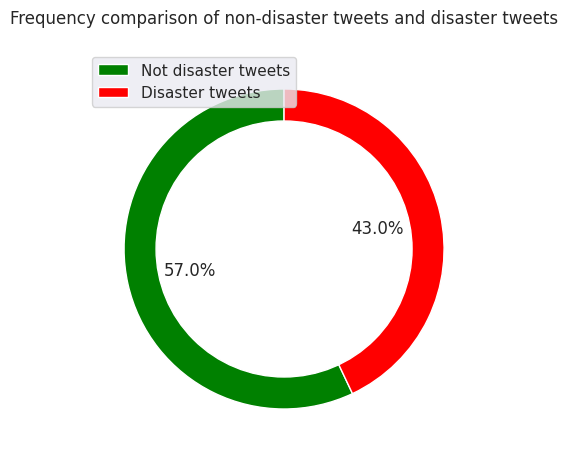

In [13]:
# Visualization of class frequencies
target_frequency = np.array([len(data_train_0), len(data_train_1)])
target_label = ["Not disaster tweets", "Disaster tweets"]
target_color = ["green", "red"]
donutplot(value = target_frequency, label = target_label, color = target_color, title = "Frequency comparison of non-disaster tweets and disaster tweets")

## Keyword

We visualize the proportion of NaN values for the **keyword** feature, as well as the top keywords (both as per *total count* and *count per tweet*) for each class.

In [14]:
# Keyword - main dataframe
keyword = list(data_train["keyword"])
nan_type_conv(keyword)
keyword_unique = unique(keyword)
keyword_unique_count = [word_counter(word, keyword) for word in keyword_unique]

keyword_0 = list(data_train_0["keyword"])
nan_type_conv(keyword_0)
keyword_0_unique_count = [word_counter(word, keyword_0) for word in keyword_unique]

keyword_1 = list(data_train_1["keyword"])
nan_type_conv(keyword_1)
keyword_1_unique_count = [word_counter(word, keyword_1) for word in keyword_unique]

keyword_df = pd.DataFrame()
keyword_df["keyword"] = keyword_unique
keyword_df["count (all tweets)"] = keyword_unique_count
keyword_df["proportion (all tweets)"] = [count/len(keyword) for count in keyword_unique_count]
keyword_df["count (non-disaster tweets)"] = keyword_0_unique_count
keyword_df["proportion (non-disaster tweets)"] = [count/len(keyword_0) for count in keyword_0_unique_count]
keyword_df["count (disaster tweets)"] = keyword_1_unique_count
keyword_df["proportion (disaster tweets)"] = [count/len(keyword_1) for count in keyword_1_unique_count]
keyword_df["absolute difference"] = abs(keyword_df["proportion (disaster tweets)"] - keyword_df["proportion (non-disaster tweets)"])

**Note:** A lot of keywords contain two words joined by *%20*, which is the URL-encoding of the *space* character.

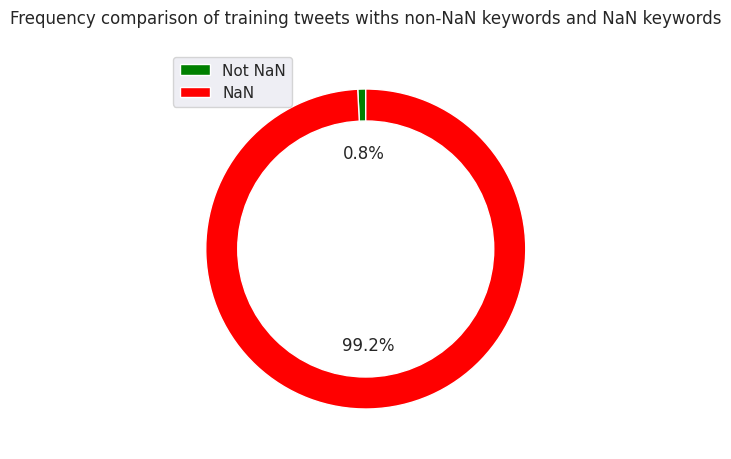

In [15]:
# 'NaN' keywords
nan_keyword_count = word_counter('NaN', keyword)
keyword_frequency = np.array([nan_keyword_count, len(keyword) - nan_keyword_count])
keyword_label = ["Not NaN", "NaN"]
keyword_color = ["green", "red"]
donutplot(value = keyword_frequency, label = keyword_label, color = keyword_color, title = "Frequency comparison of training tweets withs non-NaN keywords and NaN keywords")

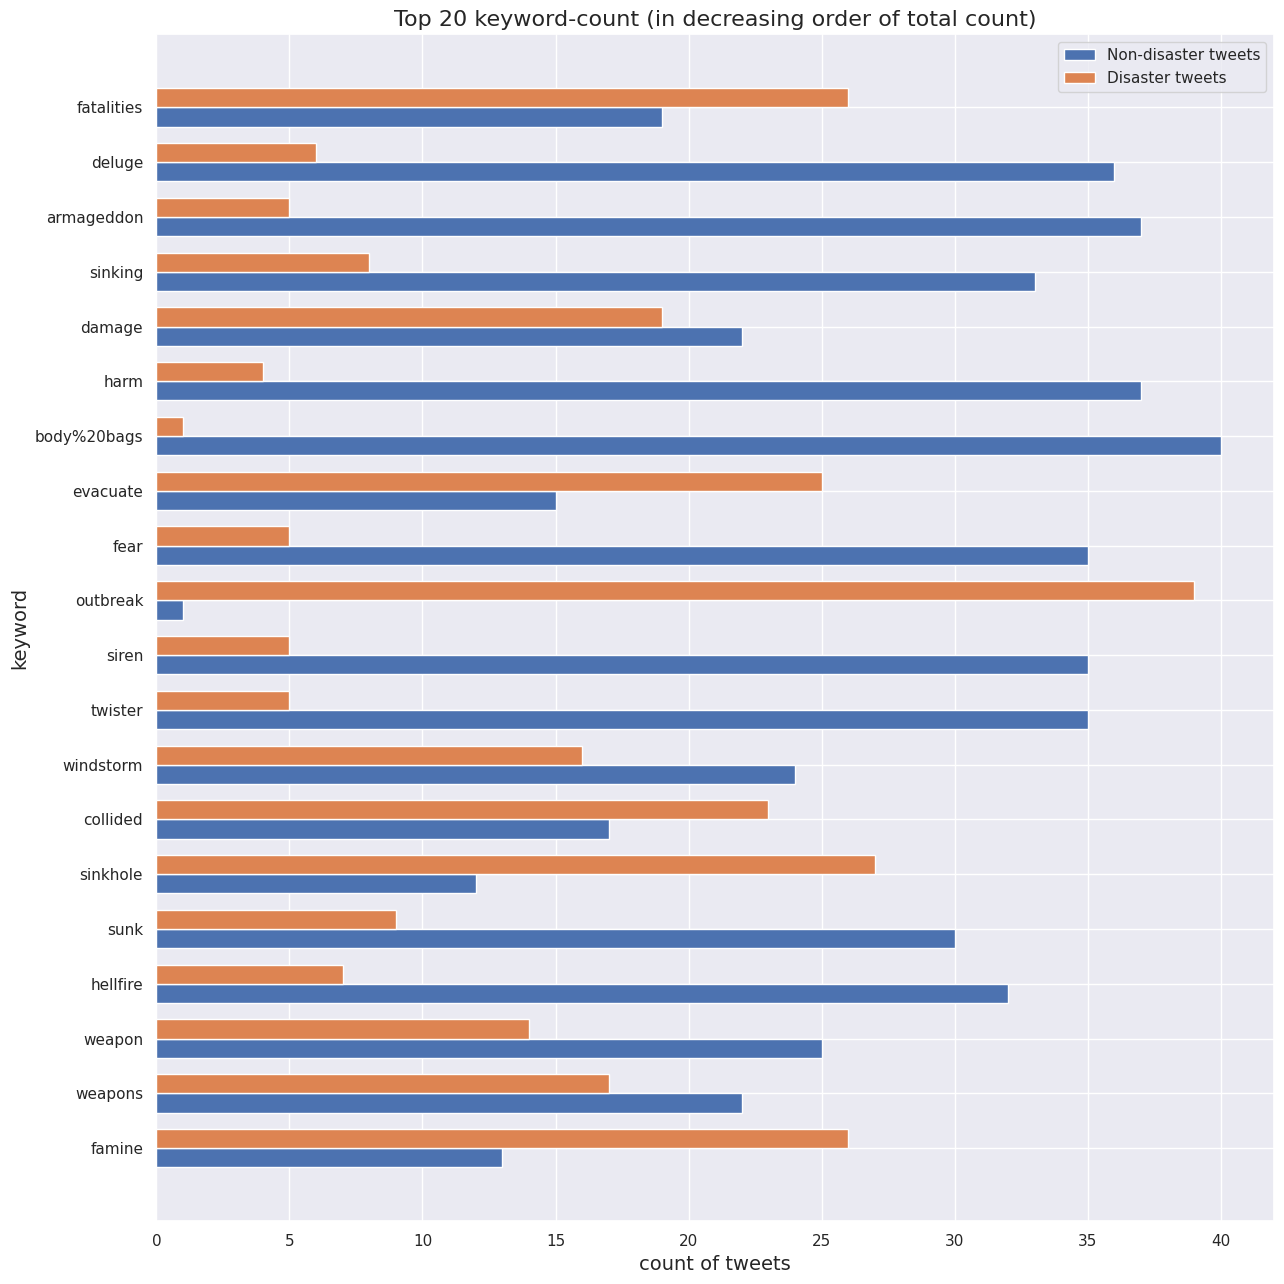

In [16]:
# Classwise keyword-count
keyword_df_count = keyword_df[["keyword", "count (all tweets)", "count (non-disaster tweets)", "count (disaster tweets)"]].sort_values(by = ["count (all tweets)"], ascending = False)
keyword_df_count.drop(0, axis = 0, inplace = True) # deleting the rows with keyword NaN

classwise_comparison_barplot(df = keyword_df_count,
                             n = 20,
                             feature = "keyword",
                             non_disaster = "count (non-disaster tweets)",
                             disaster = "count (disaster tweets)",
                             xlabel = "count of tweets",
                             ylabel = "keyword",
                             title = "Top 20 keyword-count (in decreasing order of total count)"
                            )

Since the size of the two classes are unequal, we cannot directly compare the count of a keyword in non-disaster tweets with the same in disaster tweets. To make valid comparison, we must scale these counts by respective class-sizes to obtain proportions of a keyword in non-disaster tweets and disaster tweets. In particular, the absolute difference of these two quantities can be considered as a measure of ability of a keyword to discriminate between non-disaster tweets and disaster tweets. For instance, if the absolute difference is close to 0, then we cannot infer anything on the status of the tweet based on keyword alone. On the other hand, a high value indicates that the keyword contributes towards classifying the tweet into a particular class.

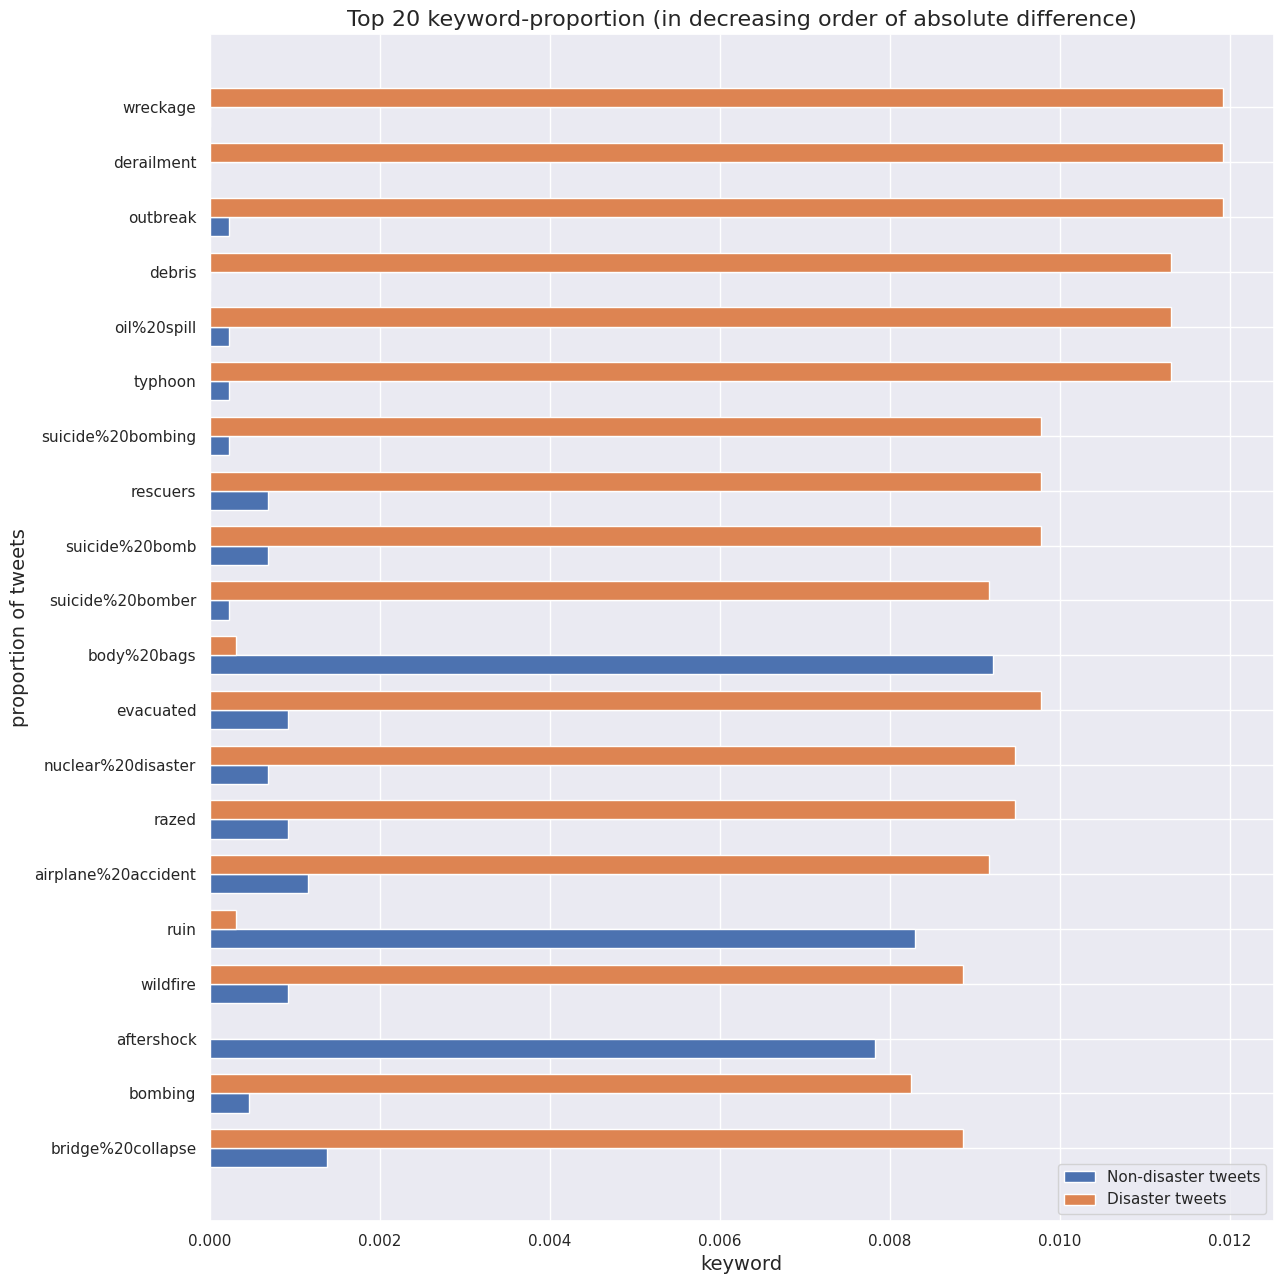

In [17]:
# Classwise keyword-proportion
keyword_df_proportion = keyword_df[["keyword", "proportion (non-disaster tweets)", "proportion (disaster tweets)", "absolute difference"]].sort_values(by = ["absolute difference"], ascending = False)
keyword_df_proportion.drop(0, axis = 0, inplace = True) # deleting the rows with keyword NaN

classwise_comparison_barplot(df = keyword_df_proportion,
                             n = 20,
                             feature = "keyword",
                             non_disaster = "proportion (non-disaster tweets)",
                             disaster = "proportion (disaster tweets)",
                             xlabel = "keyword",
                             ylabel = "proportion of tweets",
                             title = "Top 20 keyword-proportion (in decreasing order of absolute difference)"
                            )

In [18]:
# 5 keywords with least absolute difference between proportion in non-disaster tweets and proportion in disaster tweets
keyword_df_proportion["keyword"].tail(5).values.tolist()

['bomb', 'weapons', 'landslide', 'flood', 'disaster']

**Observation:** The $5$ keywords with least absolute difference between their respective proportions in non-disaster tweets and disaster tweets are usually associated with occurances of disasters. Although these words are used in non-disastrous contexts, for example *landslide victory is an election* or *flood of joyful tears* etc, it is still surprising for these to qualify as keywords in the non-disaster tweets.

## Location

We visualize the proportion of NaN values for the **location** feature, as well as the top keywords (both as per *total count* and *count per tweet*) for each class.

In [19]:
# Location - main dataframe
location = list(data_train["location"])
nan_type_conv(location)
location_unique = unique(location)
location_unique_count = [word_counter(word, location) for word in location_unique]

location_0 = list(data_train_0["location"])
nan_type_conv(location_0)
location_0_unique_count = [word_counter(word, location_0) for word in location_unique]

location_1 = list(data_train_1["location"])
nan_type_conv(location_1)
location_1_unique_count = [word_counter(word, location_1) for word in location_unique]

location_df = pd.DataFrame()
location_df["location"] = location_unique
location_df["count (all tweets)"] = location_unique_count
location_df["proportion (all tweets)"] = [count/len(location) for count in location_unique_count]
location_df["count (non-disaster tweets)"] = location_0_unique_count
location_df["proportion (non-disaster tweets)"] = [count/len(location_0) for count in location_0_unique_count]
location_df["count (disaster tweets)"] = location_1_unique_count
location_df["proportion (disaster tweets)"] = [count/len(location_1) for count in location_1_unique_count]
location_df["absolute difference"] = abs(location_df["proportion (disaster tweets)"] - location_df["proportion (non-disaster tweets)"])

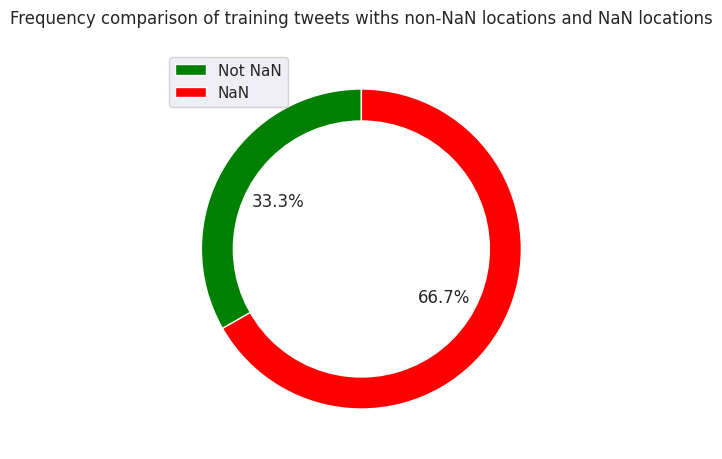

In [20]:
# 'NaN' locations
nan_location_count = word_counter('NaN', location)
location_frequency = np.array([nan_location_count, len(location) - nan_location_count])
location_label = ["Not NaN", "NaN"]
location_color = ["green", "red"]
donutplot(value = location_frequency, label = location_label, color = location_color, title = "Frequency comparison of training tweets withs non-NaN locations and NaN locations")

**Note:** In the visualizations of classwise comparison of most features, including keyword and location, we produce only a few observations of the feature of interest due to the large number of distinct textual value taken by these features. The selection of these observations are done by considering certain attributes such as *total count* and choosing the top observations according to that attribute.

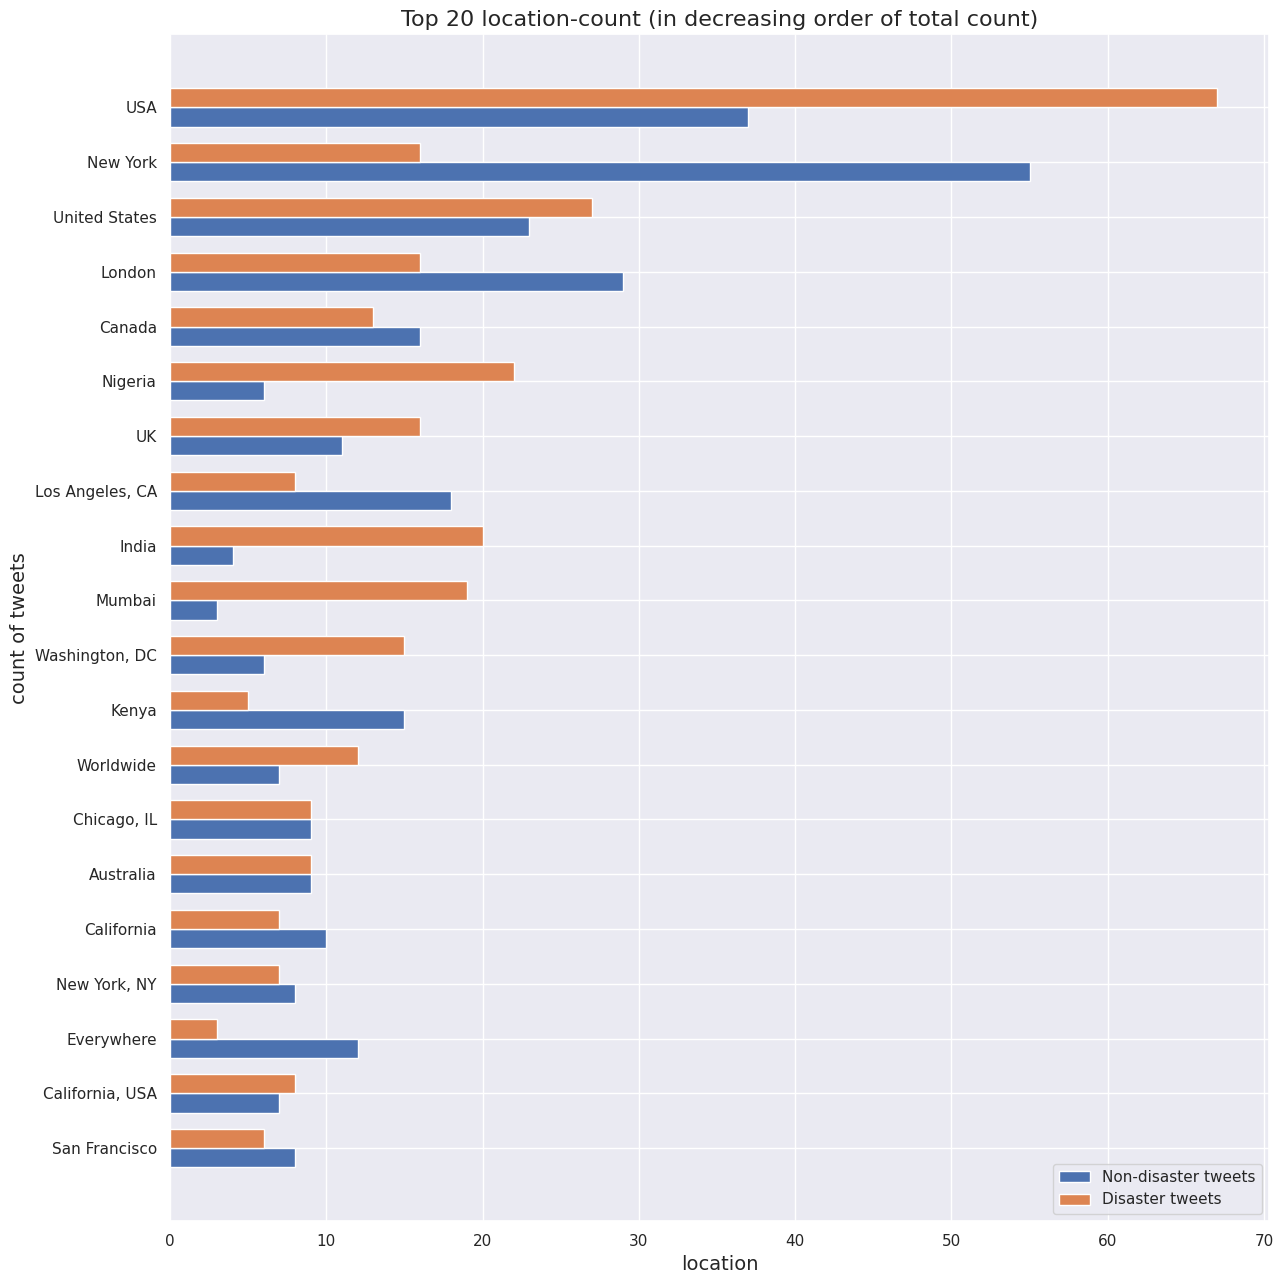

In [21]:
# Classwise location-count
location_df_count = location_df[["location", "count (all tweets)", "count (non-disaster tweets)", "count (disaster tweets)"]].sort_values(by = ["count (all tweets)"], ascending = False)
location_df_count.drop(0, axis = 0, inplace = True) # deleting the rows with location NaN

classwise_comparison_barplot(df = location_df_count,
                             n = 20,
                             feature = "location",
                             non_disaster = "count (non-disaster tweets)",
                             disaster = "count (disaster tweets)",
                             xlabel = "location",
                             ylabel = "count of tweets",
                             title = "Top 20 location-count (in decreasing order of total count)"
                            )

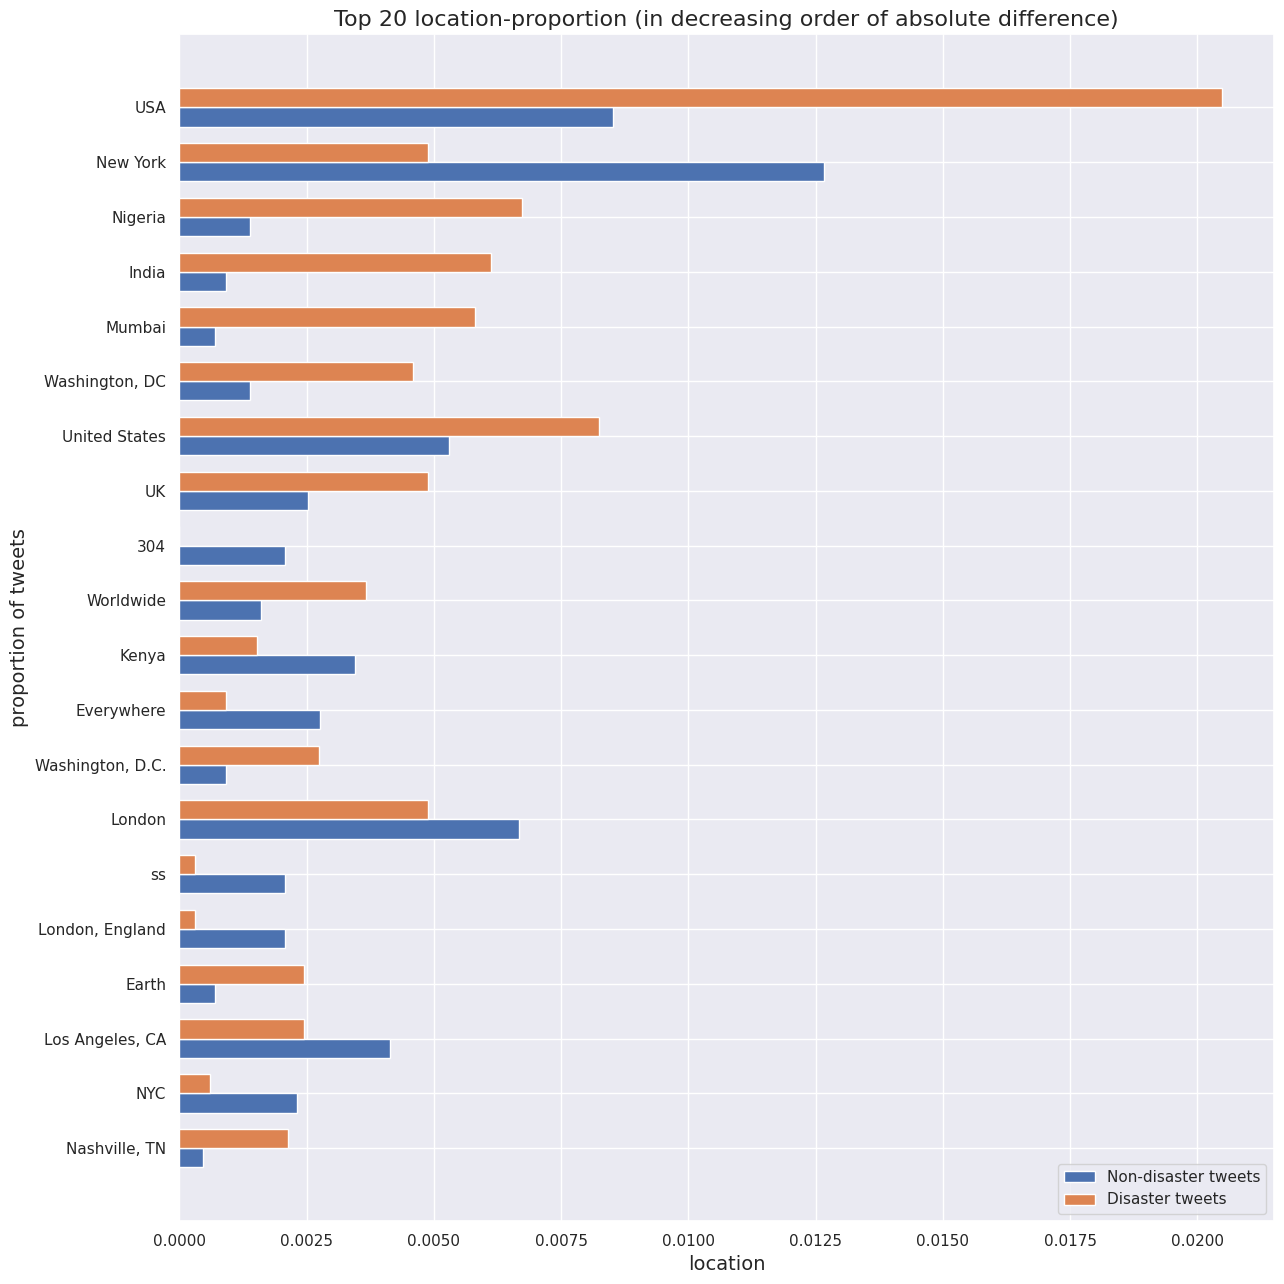

In [22]:
# Classwise location-proportion
location_df_proportion = location_df[["location", "proportion (non-disaster tweets)", "proportion (disaster tweets)", "absolute difference"]].sort_values(by = ["absolute difference"], ascending = False)
location_df_proportion.drop(0, axis = 0, inplace = True) # deleting the rows with location NaN

classwise_comparison_barplot(df = location_df_proportion,
                             n = 20,
                             feature = "location",
                             non_disaster = "proportion (non-disaster tweets)",
                             disaster = "proportion (disaster tweets)",
                             xlabel = "location",
                             ylabel = "proportion of tweets",
                             title = "Top 20 location-proportion (in decreasing order of absolute difference)"
                            )

## Number of Characters

We examine the distribution of number of characters per tweet for both the class of non-disaster tweets and the class of disaster tweets.

In [23]:
# Function to visualise classwise comparison of feature distribution - histograms in two separate subplots
def classwise_comparison_subplot(feature_train_0, feature_train_1, binwidth, title_0, title_1, ylimit, xlabel, ylabel, suptitle):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6.5))

    xmin = np.min([feature_train_0.min(), feature_train_1.min()])
    xmax = np.max([feature_train_0.max(), feature_train_1.max()])

    sns.histplot(feature_train_0, ax = ax1, color = "green", binwidth = binwidth)
    ax1.set_title(title_0, fontsize = 14)
    ax1.set_xlim([xmin - 0.5, xmax + 0.5])
    ax1.set_ylim([0, ylimit])
    ax1.set_xlabel(xlabel, fontsize = 14)
    ax1.set_ylabel(ylabel, fontsize = 14)

    sns.histplot(feature_train_1, ax = ax2, color = "red", binwidth = binwidth)
    ax2.set_title(title_1, fontsize = 14)
    ax2.set_xlim([xmin - 0.5, xmax + 0.5])
    ax2.set_ylim([0, ylimit])
    ax2.set_xlabel(xlabel, fontsize = 14)
    ax2.set_ylabel("")

    fig.suptitle(suptitle, y = 1.0, fontsize = 16)
    plt.show()

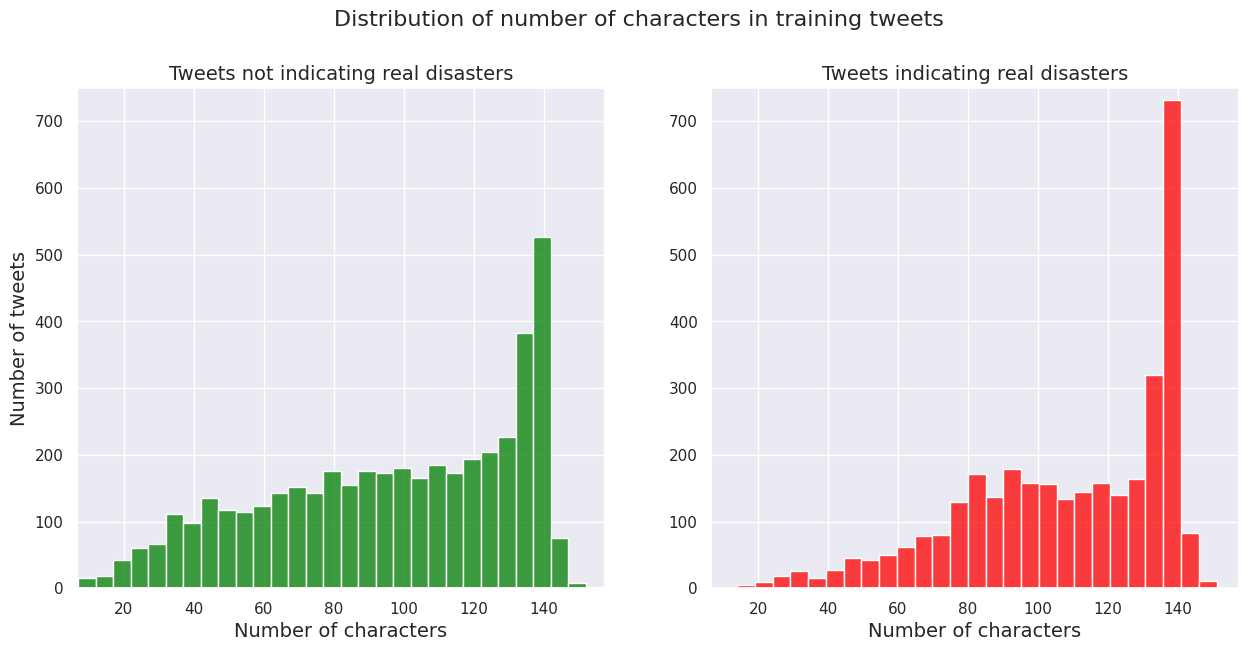

In [24]:
# Distribution of number of characters in tweets
data_train_0_char = data_train_0['text'].str.len()
data_train_1_char = data_train_1['text'].str.len()

classwise_comparison_subplot(feature_train_0 = data_train_0_char,
                             feature_train_1 = data_train_1_char,
                             binwidth = 5,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 750,
                             xlabel = "Number of characters",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of number of characters in training tweets"
                            )

## Number of Words

We examine the distribution of number of words per tweet for both the class of non-disaster tweets and the class of disaster tweets.

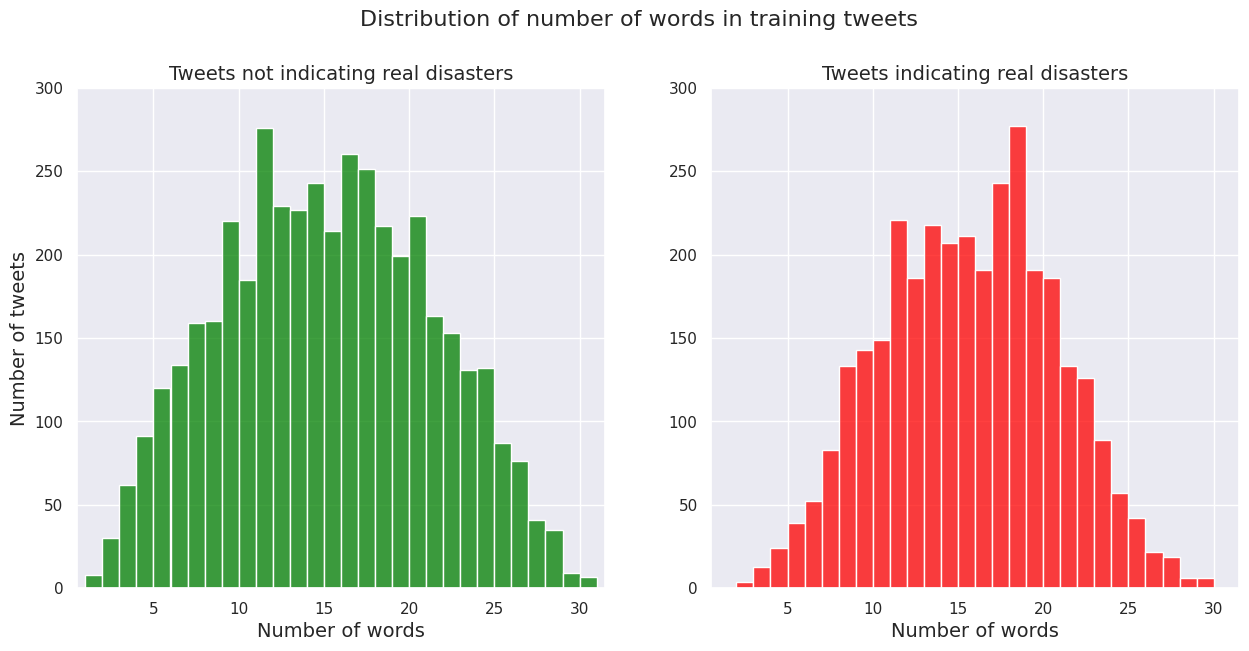

In [25]:
# Distribution of number of words in tweets
data_train_0_word = data_train_0["text"].str.split().map(lambda x: len(x))
data_train_1_word = data_train_1["text"].str.split().map(lambda x: len(x))

classwise_comparison_subplot(feature_train_0 = data_train_0_word,
                             feature_train_1 = data_train_1_word,
                             binwidth = 1,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 300,
                             xlabel = "Number of words",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of number of words in training tweets"
                            )

## Length of Words

Next we analyze the distribution of average word-length in tweets for both the class of non-disaster tweets and the class of disaster tweets.

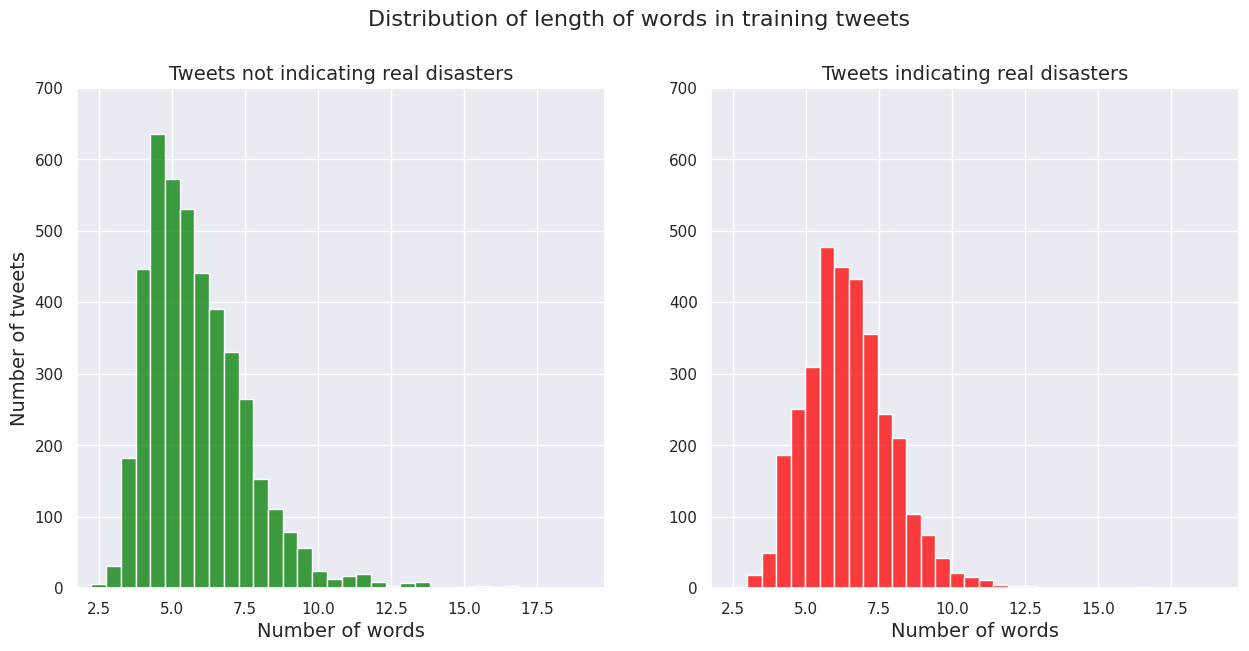

In [26]:
# Distribution of average word-length in tweets
data_train_0_avg = data_train_0["text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_train_1_avg = data_train_1["text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

classwise_comparison_subplot(feature_train_0 = data_train_0_avg,
                             feature_train_1 = data_train_1_avg,
                             binwidth = 0.5,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 700,
                             xlabel = "Number of words",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of length of words in training tweets"
                            )

## URLs

We examine the distribution of number of URLs per tweet for both the class of non-disaster tweets and the class of disaster tweets.

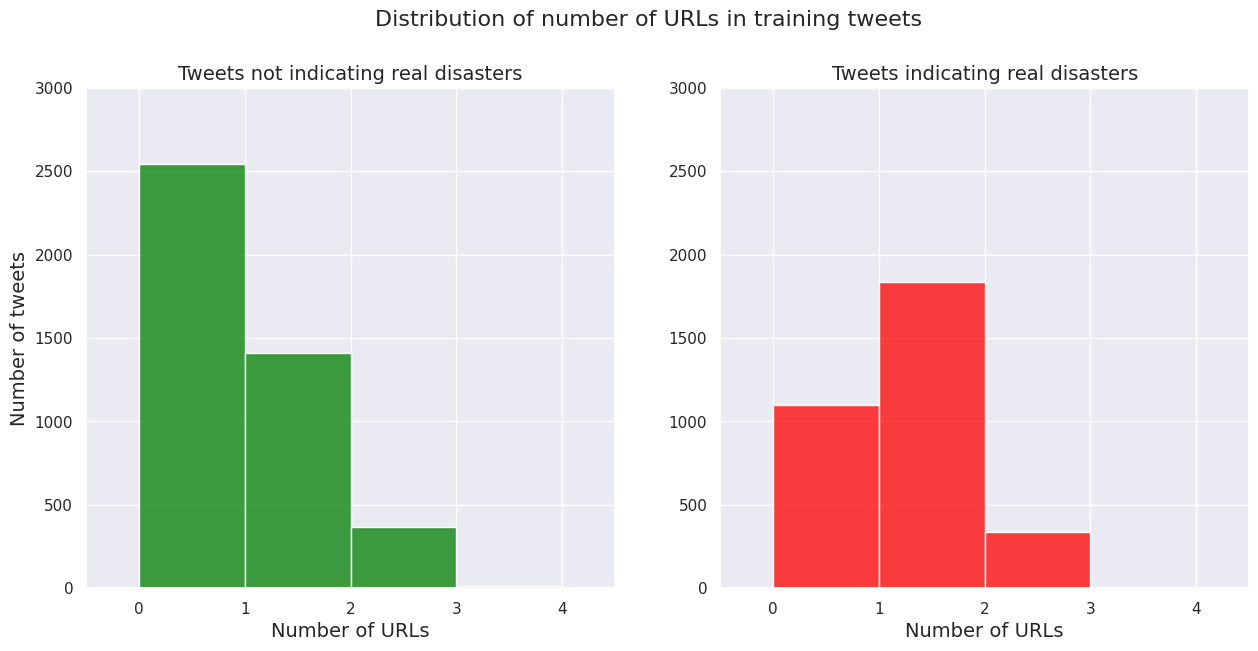

In [27]:
# Distribution of number of urls in tweets
url_train_0_count = data_train_0["text"].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
url_train_1_count = data_train_1["text"].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

classwise_comparison_subplot(feature_train_0 = url_train_0_count,
                             feature_train_1 = url_train_1_count,
                             binwidth = 1,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 3000,
                             xlabel = "Number of URLs",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of number of URLs in training tweets"
                            )

## Hashtags (#)

We examine the distribution of number of hashtags per tweet for both the class of non-disaster tweets and the class of disaster tweets.

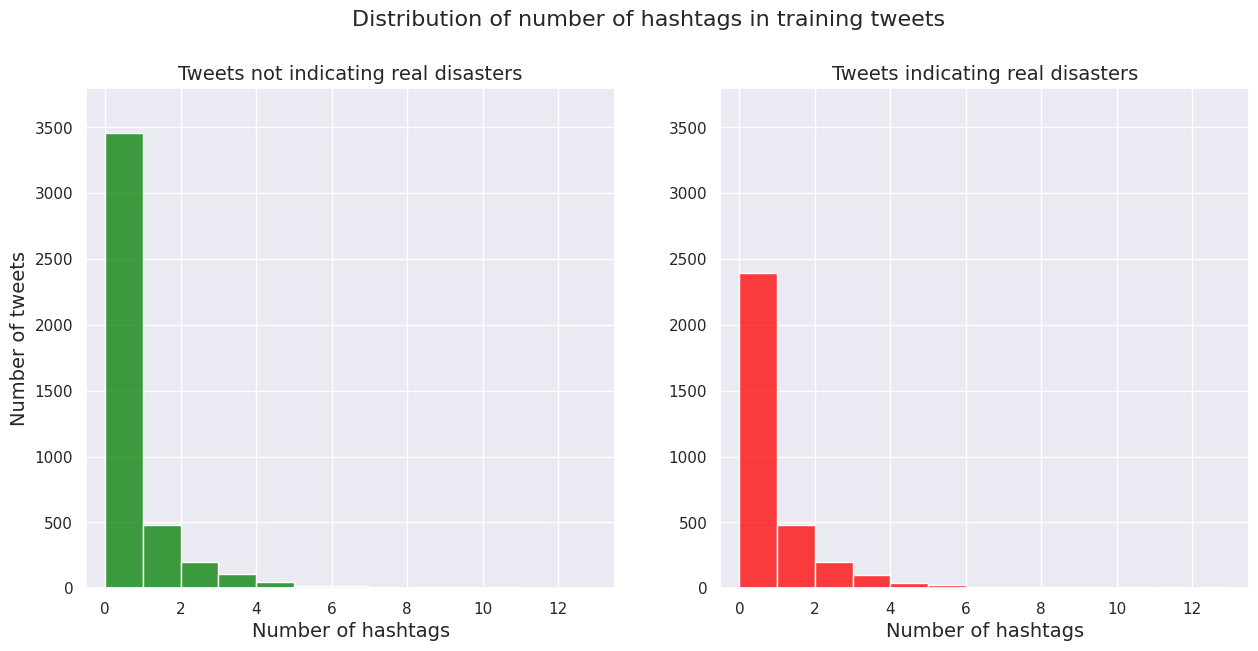

In [28]:
# Distribution of number of hashtags in tweets
hashtag_train_0_count = data_train_0["text"].apply(lambda x: len([c for c in str(x) if c == '#']))
hashtag_train_1_count = data_train_1["text"].apply(lambda x: len([c for c in str(x) if c == '#']))

classwise_comparison_subplot(feature_train_0 = hashtag_train_0_count,
                             feature_train_1 = hashtag_train_1_count,
                             binwidth = 1,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 3800,
                             xlabel = "Number of hashtags",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of number of hashtags in training tweets"
                            )

## Mentions (@)

We examine the distribution of number of mentions per tweet for both the class of non-disaster tweets and the class of disaster tweets.

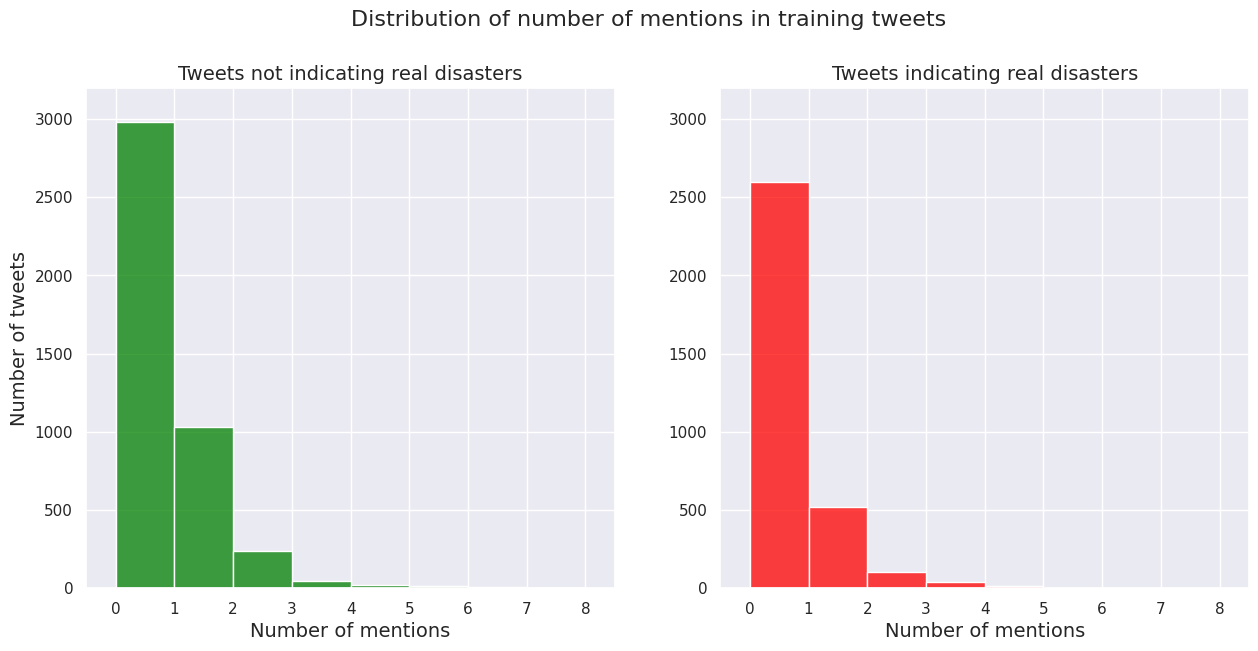

In [29]:
# Distribution of number of mentions in tweets
mention_train_0_count = data_train_0["text"].apply(lambda x: len([c for c in str(x) if c == '@']))
mention_train_1_count = data_train_1["text"].apply(lambda x: len([c for c in str(x) if c == '@']))

classwise_comparison_subplot(feature_train_0 = mention_train_0_count,
                             feature_train_1 = mention_train_1_count,
                             binwidth = 1,
                             title_0 = "Tweets not indicating real disasters",
                             title_1 = "Tweets indicating real disasters",
                             ylimit = 3200,
                             xlabel = "Number of mentions",
                             ylabel = "Number of tweets",
                             suptitle = "Distribution of number of mentions in training tweets"
                            )

# Text Normalization

We consider a number of [**text normalization**](https://en.wikipedia.org/wiki/Text_normalization) processes, namely conversion to [**lowercase**](https://en.wikipedia.org/wiki/Letter_case), removal of [**whitespaces**](https://en.wikipedia.org/wiki/Whitespace_character), removal of [**punctuations**](https://en.wikipedia.org/wiki/Punctuation), removal of [**unicode characters**](https://en.wikipedia.org/wiki/List_of_Unicode_characters) (including [**HTML**](https://en.wikipedia.org/wiki/HTML) tags, [**emojis**](https://en.wikipedia.org/wiki/Emoji), and [**URL**](https://en.wikipedia.org/wiki/URL)s starting with [**http**](https://en.wikipedia.org/wiki/HTTP)), substitution of [**acronyms**](https://en.wikipedia.org/wiki/Acronym), substitution of [**contractions**](https://en.wikipedia.org/wiki/Contraction_(grammar)), removal of [**stop words**](https://en.wikipedia.org/wiki/Stop_word), [**spelling**](https://en.wikipedia.org/wiki/Spelling) correction, [**stemming**](https://en.wikipedia.org/wiki/Stemming), [**lemmatization**](https://en.wikipedia.org/wiki/Lemmatization), discardment of non-alphabetic words, and retention of relevant [**parts of speech**](https://en.wikipedia.org/wiki/Part_of_speech). At the end of the section, we combine all the processes into one single function and apply it on the training tweets.

## Convertion to Lowercase

We convert all alphabetical characters of the tweets to lowercase so that the models do not differentiate identical words due to case-sensitivity. For example, without the normalization, *Sun* and *sun* would have been treated as two different words, which is not useful in the present context.

In [30]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


## Removal of Whitespaces

We remove the unnecessary empty spaces from the tweets.

In [31]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


## Removal of Punctuations

Mostly the punctuations do not play any role in predicting whether a particular tweet indicate disaster or not. Thus we prevent them from contaminating the classification procedures by removing them from the tweets. However, we keep **apostrophe** since most of the contractions contain this punctuation and will be automatically taken care of once we convert the contractions.

In [32]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuation!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuation!!!!
Output: Here's an example of a string with punctuation


## Removal of Unicode Characters

The training tweets are typically sprinkled with emojis, URLs, punctuation and other symbols that do not contribute meaningfully to our analysis, but instead create noise in the learning procedure. Some of these symbols are unique, while the rest usually translate into unicode strings. We remove these irrelevant characters from the data using the regular expression module.

In [33]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/c/nlp-getting-started/overview"> Natural Language Processing with Disaster Tweets </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/c/nlp-getting-started/overview"> Natural Language Processing with Disaster Tweets </a>
Output:  Natural Language Processing with Disaster Tweets 


In [34]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "Just happened a terrible car crash 😟"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: Just happened a terrible car crash 😟
Output: Just happened a terrible car crash 


In [35]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


## Substitution of Acronyms

**What are acronyms?** Acronyms are shortened forms of phrases, generally found in informal writings such as personal messages. For instance, *for your information* is written as *fyi* and *by the way* is written as *btw*. These time and effort-saving acronyms have received almost universal acceptance in social media platforms including twitter. For the sake of proper modeling, we convert the acronyms, appearing in the tweets, back to their respective original forms.

In [36]:
# Dictionary of acronyms
acronyms_url = './data/english_acronyms_lowercase.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict["fyi"]))

Example: Original form of the acronym 'fyi' is 'for your information'


In [37]:
# Dataframe of acronyms
dict_to_df(acronyms_dict, "acronym", "original").head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [38]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

In [39]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


## Substitution of Contractions

**What are contractions?** A contraction is a shortened form of a word or a phrase, obtained by dropping one or more letters.

These are commonly used in everyday speech, written dialogue, informal writing and in situations where space is limited or costly, such as advertisements. Usually the missing letters are indicated by an apostrophe, but there are exceptions. Examples: I'm = I am, let's = let us, won't = would not, howdy = how do you do.

We have compiled an extensive list of English contractions, which can be found in the attached .json file titled *english_contractions_lowercase*. The list is largely based on information obtained from the wikipedia page on *list of English contractions*. Note that the file only considers contractions in lowercase, i.e. it assumes that the textual data have already been transformed to lowercase before substituting the contractions. For example, the process will convert *i'll* to *i shall* but will leave *I'll* unchanged.

In [40]:
# Dictionary of contractions
contractions_url = './data/english_contractions_lowercase.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [41]:
# Dataframe of contractions
dict_to_df(contractions_dict, "contraction", "original").head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example **i'd** can come from both **i had** and **i would**. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like **had** and **would**, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection.

In [42]:
# List of contractions
contractions_list = list(contractions_dict.keys())

In [43]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


## Removal of Stopwords

Several words, primarily pronouns, prepositions, modal verbs etc, are identified not to have much effect on the classification procedure. To get rid of the unwanted contamination effect, we remove these words.

In [44]:
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [45]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


## Spelling Correction

The classification procedure cannot take mispellings into consideration and treats a word and its misspelt version as separate words. For this reason it is necessary to conduct spelling correction before feeding the data to the classification procedure.

In [46]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_list_corrected.append(spell.correction(word))
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


## Stemming and Lemmatization

**Stemming** is the process of reducing the words to their root form or *stem*. It reduces related words to the same *stem* even if the stem is not a dictionary word. For example, the words *introducing*, *introduced*, *introduction* reduce to a common word *introduce*. However, the process often produces stems that are not actual words.

In [47]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


The stems *introduc*, *lemmat* and *improv* are not actual words. **Lemmatization** offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

In [48]:
from spacy.cli import download

def ensure_spacy_model(model_name="en_core_web_sm"):
    try:
        # Try to load the model to check if it's already installed
        spacy.load(model_name)
        print(f"Model '{model_name}' is already installed.")
    except OSError:
        # If the model is not installed, download it
        print(f"Model '{model_name}' not found. Downloading...")
        download(model_name)
        print(f"Model '{model_name}' downloaded.")

# Use the function to ensure the model is downloaded
ensure_spacy_model()

Model 'en_core_web_sm' not found. Downloading...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Model 'en_core_web_sm' downloaded.


In [49]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


## Discardment of Non-alphabetic Words

The non-alphabetic words are not numerous and create unnecessary diversions in the context of classifying tweets into non-disaster and disaster categories. Hence we discard these words.

In [50]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


## Parts of Speech

The **parts of speech** provide a great tool to select a subset of words that are more likely to contribute in the classification procedure and discard the rest to avoid noise. The idea is to select a number of parts of speech that are important to the context of the problem. Then we partition the words in a given text into several subsets corresponding to each part of speech and keep only those subsets corresponding to the selected parts of speech. 

In [51]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    # keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


For an extensive list of part-of-speech tags, see [**alphabetical list of part-of-speech tags used in the Penn Treebank Project**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

## Removal of Additional Stopwords

Analyzing the data, we observe that several unnecessary words, which are not included in the ready-made set of **stopwords**, keep appearing in the text corpus. We discard these words to remove noise in the classification procedure.

In [52]:
# Additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

## Integration of the Processes

In [53]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_http(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    # text = pyspellchecker(text)
    #text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all into 1 SINGLE FUNCTION 🙂 & apply on #training_tweets https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all into 1 SINGLE FUNCTION 🙂 & apply on #training_tweets https://en.wikipedia.org/wiki/Text_normalization
Output: combine function apply trainingtweets httpsenwikipediaorgwikitextnormalization


## Implementation on Training Tweets

Next we implement the text normalization on the training tweets.

In [54]:
data_train["tokens"] = data_train["text"].apply(lambda x: regexp.tokenize(x))
data_train["keyword plus"] = data_train["keyword"].fillna(" ")
data_train["location plus"] = data_train["location"].fillna(" ")
data_train["text plus"] = data_train["keyword plus"] + " " + data_train["location plus"] + " " + data_train["text"]
data_train["tokens plus"] = data_train["text plus"].apply(regexp.tokenize)

data_train["normalized text"] = data_train["text"].apply(text_normalizer) # implementing text normalization
data_train["normalized tokens"] = data_train["normalized text"].apply(lambda x: regexp.tokenize(x))
data_train["normalized text plus"] = data_train["keyword plus"] + " " + data_train["location plus"] + " " + data_train["normalized text"]
data_train["normalized tokens plus"] = data_train["normalized text plus"].apply(lambda x: regexp.tokenize(x))

data_train[["id", "keyword", "location", "text", "normalized text plus", "normalized tokens plus", "target"]]

,id,keyword,location,text,normalized text plus,normalized tokens plus,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah,"[deeds, reason, earthquake, allah]",1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,fire ronge sask canada,"[fire, ronge, sask, canada]",1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,residents asked officers evacuation place ...,"[residents, asked, officers, evacuation, place...",1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires orders california,"[people, receive, wildfires, orders, california]",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,got photo ruby alaska smoke wildfires pour...,"[got, photo, ruby, alaska, smoke, wildfires, p...",1
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,cranes holding bridge collapse homes,"[cranes, holding, bridge, collapse, homes]",1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,control fires california even part state t...,"[control, fires, california, even, part, state...",1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,volcano hawaii,"[volcano, hawaii]",1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,police investigating ebike collided car eb...,"[police, investigating, ebike, collided, car, ...",1


We implement the text normalization on the test tweets as well.

In [55]:
data_test["tokens"] = data_test["text"].apply(lambda x: regexp.tokenize(x))
data_test["keyword plus"] = data_test["keyword"].fillna(" ")
data_test["location plus"] = data_test["location"].fillna(" ")
data_test["text plus"] = data_test["keyword plus"] + " " + data_test["location plus"] + " " + data_test["text"]
data_test["tokens plus"] = data_test["text plus"].apply(lambda x: regexp.tokenize(x))

data_test["normalized text"] = data_test["text"].apply(text_normalizer) # implementing text normalization
data_test["normalized tokens"] = data_test["normalized text"].apply(lambda x: regexp.tokenize(x))
data_test["normalized text plus"] = data_test["keyword plus"] + " " + data_test["location plus"] + " " + data_test["normalized text"]
data_test["normalized tokens plus"] = data_test["normalized text plus"].apply(lambda x: regexp.tokenize(x))

data_test_target = data_test.copy()
data_test_target['target'] = '?'
data_test_target[["id", "keyword", "location", "text", "normalized text plus", "normalized tokens plus", "target"]]

,id,keyword,location,text,normalized text plus,normalized tokens plus,target
0,0,NaN,NaN,Just happened a terrible car crash,happened car crash,"[happened, car, crash]",?
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake cities stay everyone,"[heard, earthquake, cities, stay, everyone]",?
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",fire spot pond fleeing street cannot save,"[fire, spot, pond, fleeing, street, cannot, save]",?
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,"[apocalypse, lighting, spokane, wildfires]",?
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills taiwan,"[typhoon, soudelor, kills, taiwan]",?
...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety faste...,"[earthquake, safety, los, angeles, safety, fas...",?
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri hurricane hit yard looks bombed s...,"[storm, ri, hurricane, hit, yard, looks, bombe...",?
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,line derailment chicago httptcoutbxlcbiuy,"[line, derailment, chicago, httptcoutbxlcbiuy]",?
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues weather outlook hwo,"[meg, issues, weather, outlook, hwo]",?


In [56]:
X = data_train['normalized text'].tolist()
y = data_train['target'].tolist()

In [57]:
del data_test_target
gc.collect()

35645

# Bag of N-grams Model

The function defined below, when fed with a text corpus, returns a dataframe consisting of all possible words along with their respective frequencies.

In [58]:
def count_words(text_list):
    CountVec = CountVectorizer(ngram_range = (1, 1))
    words = CountVec.fit_transform(text_list)
    count_words_df = pd.DataFrame()
    count_words_df['Words'] = CountVec.get_feature_names_out()
    count_words_df['Frequency'] = words.toarray().sum(axis = 0)
    count_words_df.sort_values(by = 'Frequency', ascending = False, inplace = True)
    return count_words_df

Similarly the next two functions return dataframes consisting of all possible bigrams and trigrams, respectively, along with their corresponding frequencies in the given text corpus.

In [59]:
def count_bigrams(text_list):
    CountVec = CountVectorizer(ngram_range = (2, 2))
    bigrams = CountVec.fit_transform(text_list)
    count_bigrams_df = pd.DataFrame()
    count_bigrams_df['Bigrams'] = CountVec.get_feature_names_out()
    count_bigrams_df['Frequency'] = bigrams.toarray().sum(axis = 0)
    count_bigrams_df.sort_values(by = 'Frequency', ascending = False, inplace = True)
    return count_bigrams_df

In [60]:
def count_trigrams(text_list):
    CountVec = CountVectorizer(ngram_range = (3, 3))
    trigrams = CountVec.fit_transform(text_list)
    count_trigrams_df = pd.DataFrame()
    count_trigrams_df['Trigrams'] = CountVec.get_feature_names_out()
    count_trigrams_df['Frequency'] = trigrams.toarray().sum(axis = 0)
    count_trigrams_df.sort_values(by = 'Frequency', ascending = False, inplace = True)
    return count_trigrams_df

Next, we construct the lists of normalized texts from both classes (non-disaster and disaster) of the training tweets.

In [61]:
X_0 = data_train[data_train['target'] == 0]['normalized text'].tolist()
X_1 = data_train[data_train['target'] == 1]['normalized text'].tolist()

Now, we display the top words and bigrams for each class of tweets in the training datasets based on their frequency of occurance.

In [62]:
display_count_words = [count_words(X_0).head(10), count_words(X_1).head(10)]
display_title_words = ["Words in non-disaster tweets", "Words in disaster tweets"]
display_side_by_side(display_count_words, display_title_words)

,Words,Frequency
3463,get,161
267,amp,149
935,body,109
3538,going,107
3567,got,91
6497,people,89
9317,video,85
5357,love,84
4998,know,83
5163,let,82


In [63]:
display_count_bigrams = [count_bigrams(X_0).head(10), count_bigrams(X_1).head(10)]
display_title_bigrams = ["Bigrams in non-disaster tweets", "Bigrams in disaster tweets"]
display_side_by_side(display_count_bigrams, display_title_bigrams)

,Bigrams,Frequency
4066,cross body,38
10605,liked video,35
2022,body bagging,21
2466,burning buildings,21
6300,fan army,17
2020,body bag,17
14491,reddit quarantine,16
3800,content policy,16
2023,body bags,16
17176,stock market,16


We shall not use trigrams in our models. Nonetheless we exhibit the top trigrams appearing in the non-disaster tweets as well as the disaster tweets.

In [64]:
display_count_trigrams = [count_trigrams(X_0).head(10), count_trigrams(X_1).head(10)]
display_title_trigrams = ["Trigrams in non-disaster tweets", "Trigrams in disaster tweets"]
display_side_by_side(display_count_trigrams, display_title_trigrams)

,Trigrams,Frequency
14655,stock market crash,16
3265,content policy goes,15
4680,effect subreddits banned,15
11713,policy goes effect,15
7542,hollywood movie trapped,15
10326,movie trapped miners,15
6615,goes effect subreddits,15
7837,ignition knock detonation,15
14819,subreddits banned quarantined,13
7263,heard bang appears,13


## Bag of Words Model (All Features)

The **bag of words** model is a way of representing text data used in *natural language processing*. The model only considers multiplicity of the words and completely disregards the grammatical structure and ordering of the words. Here we fit the model, treating each word as a feature and observe the **average F1-score obtained from $5$ repetitions of $6$-fold cross-validation** using different classifiers.

In [65]:
CountVec1 = CountVectorizer(ngram_range = (1, 1))
X_fit_transform_1 = CountVec1.fit_transform(X)
f1_score_df(X_fit_transform_1, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.732266
1,KNN Classifier,0.009949
2,Decision Tree,0.700647
3,SVM (linear kernel),0.706426
4,SVM (RBF kernel),0.733883
5,Random Forest,0.612824
6,Stochastic Gradient Descent,0.733545
7,Ridge Classifier,0.723757
8,XGBoost Classifier,0.646295
9,AdaBoost Classifier,0.681096


We observe that **logistic regression**, **SVM (linear kernel)**, **SVM (RBF kernel)**, **stochastic gradient descent** and **ridge classifier** works well in this prediction scheme, compared to the other classifiers.

## Bag of Words Model (Selected Features)

Next, we fit the same model, considering only the top $10\%$ words as a feature and observe the mean F1-score resulting from cross-validations using different classifiers.

In [66]:
cutoff = 0.1 # The model considers top 10% features

X_fit_transform_1_df = pd.DataFrame(X_fit_transform_1.toarray(), columns = CountVec1.get_feature_names_out())
X_fit_transform_1_df_sorted = X_fit_transform_1_df.copy()
X_fit_transform_1_df_sorted.loc[len(X_fit_transform_1_df_sorted.index)] = X_fit_transform_1.toarray().sum(axis = 0)
X_fit_transform_1_df_sorted.sort_values(by = len(X_fit_transform_1_df_sorted.index)-1, axis = 1, ascending = False, inplace = True, kind = 'quicksort', na_position = 'last')
X_fit_transform_1_df_sorted.drop(X_fit_transform_1_df_sorted.tail(1).index, inplace = True)
select = math.floor(cutoff*len(X_fit_transform_1_df_sorted.columns))
X_fit_transform_1_df_selected = X_fit_transform_1_df_sorted.iloc[:, 0:select]
X_fit_transform_1_selected = sparse.csr_matrix(X_fit_transform_1_df_selected.to_numpy())

f1_score_df(X_fit_transform_1_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.726184
1,KNN Classifier,0.030499
2,Decision Tree,0.693056
3,SVM (linear kernel),0.714754
4,SVM (RBF kernel),0.731564
5,Random Forest,0.565723
6,Stochastic Gradient Descent,0.723839
7,Ridge Classifier,0.721512
8,XGBoost Classifier,0.648471
9,AdaBoost Classifier,0.682122


As in the model considering all words as features, **logistic regression**, **SVM (linear kernel)**, **SVM (RBF kernel)**, **stochastic gradient descent** and **ridge classifier** works well in the model considering only the top layer of words, compared to the other classifiers.

## Bag of Bigrams Model (All Features)

Next we consider bag of bigrams (pair of consecutive words) model instead of bag of words model.

In [67]:
CountVec2 = CountVectorizer(ngram_range = (2, 2))
X_fit_transform_2 = CountVec2.fit_transform(X)
f1_score_df(X_fit_transform_2, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:12:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.626423
1,KNN Classifier,0.000000
2,Decision Tree,0.535247
3,SVM (linear kernel),0.551699
4,SVM (RBF kernel),0.575287
5,Random Forest,0.328103
6,Stochastic Gradient Descent,0.554394
7,Ridge Classifier,0.563307
8,XGBoost Classifier,0.381241
9,AdaBoost Classifier,0.401743


## Bag of Bigrams Model (Selected Features)

Next we consider the same model with the top quarter of bigrams.

In [68]:
cutoff = 0.25

X_fit_transform_2_df = pd.DataFrame(X_fit_transform_2.toarray(), columns = CountVec2.get_feature_names_out())
X_fit_transform_2_df_sorted = X_fit_transform_2_df.copy()
X_fit_transform_2_df_sorted.loc[len(X_fit_transform_2_df_sorted.index)] = X_fit_transform_2.toarray().sum(axis = 0)
X_fit_transform_2_df_sorted.sort_values(by = len(X_fit_transform_2_df_sorted.index)-1, axis = 1, ascending = False, inplace = True, kind = 'quicksort', na_position = 'last')
X_fit_transform_2_df_sorted.drop(X_fit_transform_2_df_sorted.tail(1).index, inplace = True)
select = math.floor(cutoff*len(X_fit_transform_2_df_sorted.columns))
X_fit_transform_2_df_selected = X_fit_transform_2_df_sorted.iloc[:, 0:select]
X_fit_transform_2_selected = sparse.csr_matrix(X_fit_transform_2_df_selected.to_numpy())

f1_score_df(X_fit_transform_2_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.625574
1,KNN Classifier,0.023866
2,Decision Tree,0.562626
3,SVM (linear kernel),0.578432
4,SVM (RBF kernel),0.608502
5,Random Forest,0.331967
6,Stochastic Gradient Descent,0.580905
7,Ridge Classifier,0.600176
8,XGBoost Classifier,0.382731
9,AdaBoost Classifier,0.403096


We observe that **logistic regression**, **decision tree**, **SVM (linear kernel)**, **SVM (RBF kernel)**, **stochastic gradient descent** and **ridge classifier** work moderately well for the bag of bigrams models but not as good as bag of words models.

## Mixture Model (All Features)

Now we consider mixture models by considering both words as well as bigrams.

In [69]:
X_fit_transform_merged_df = pd.concat([X_fit_transform_1_df, X_fit_transform_2_df], axis = 1)
X_fit_transform_merged = sparse.csr_matrix(X_fit_transform_merged_df.to_numpy())
f1_score_df(X_fit_transform_merged, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.736551
1,KNN Classifier,0.000610
2,Decision Tree,0.700932
3,SVM (linear kernel),0.715989
4,SVM (RBF kernel),0.726142
5,Random Forest,0.579376
6,Stochastic Gradient Descent,0.731330
7,Ridge Classifier,0.729666
8,XGBoost Classifier,0.647409
9,AdaBoost Classifier,0.680522


## Mixture Model (Selected Features)

Here we consider a mixture of features by considering top $10\%$ words and top $25\%$ bigrams.

In [70]:
X_fit_transform_merged_df_selected = pd.concat([X_fit_transform_1_df_selected, X_fit_transform_2_df_selected], axis = 1)
X_fit_transform_merged_selected = sparse.csr_matrix(X_fit_transform_merged_df_selected.to_numpy())
f1_score_df(X_fit_transform_merged_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.730679
1,KNN Classifier,0.016450
2,Decision Tree,0.693668
3,SVM (linear kernel),0.710285
4,SVM (RBF kernel),0.733800
5,Random Forest,0.562386
6,Stochastic Gradient Descent,0.731836
7,Ridge Classifier,0.726192
8,XGBoost Classifier,0.647486
9,AdaBoost Classifier,0.681527


We observe that the performances under mixture models are more or less similar to those under bag of words models.

In [71]:
del X_fit_transform_1_df, X_fit_transform_1_df_sorted, X_fit_transform_2_df, X_fit_transform_2_df_sorted, X_fit_transform_merged_df, X_fit_transform_1_df_selected, X_fit_transform_2_df_selected, X_fit_transform_merged_df_selected
gc.collect()

479

# TF-IDF Model

Next we implement the **term frequency-inverse document frequency** (TFIDF) model.

The *term frequency* (TF) is the number of times a word appears in a text, divded by the total number of words appearing in the text. On the other hand, *inverse document frequency* (IDF) is the logarithm of the number of texts in the corpus, divided by the number of texts that contain the specific word. IDF determines the weight of rare words across all texts in the corpus. TF-IDF is the product of these two quantities. It objectively evaluates how relevant a word is to a text in a collection of texts, taking into consideration that some words appear more frequently in general.

## Bag of Words Model (All Features)

In [72]:
TfidfVec1 = TfidfVectorizer(ngram_range = (1, 1))
X_fit_transform_tfidf_1 = TfidfVec1.fit_transform(X)
f1_score_df(X_fit_transform_tfidf_1, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:36:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.742493
1,KNN Classifier,0.684004
2,Decision Tree,0.682926
3,SVM (linear kernel),0.724146
4,SVM (RBF kernel),0.723390
5,Random Forest,0.612771
6,Stochastic Gradient Descent,0.725119
7,Ridge Classifier,0.738114
8,XGBoost Classifier,0.653314
9,AdaBoost Classifier,0.679244


We observe that **logistic regression**, **SVM (linear kernel)**, **SVM (RBF kernel)**, **stochastic gradient descent** and **ridge classifier** works well in this prediction scheme, compared to the other classifiers. In fact, logistic regression, the classifier returning the highest **F1-score**, has a slight improvement over the same model without TFIDF implementation.

## Bag of Words Model (Selected Features)

In [73]:
cutoff = 0.1

X_fit_transform_tfidf_1_df = pd.DataFrame(X_fit_transform_tfidf_1.toarray(), columns = TfidfVec1.get_feature_names_out())
X_fit_transform_tfidf_1_df_sorted = X_fit_transform_tfidf_1_df.copy()
X_fit_transform_tfidf_1_df_sorted.loc[len(X_fit_transform_tfidf_1_df_sorted.index)] = X_fit_transform_tfidf_1.toarray().sum(axis = 0)
X_fit_transform_tfidf_1_df_sorted.sort_values(by = len(X_fit_transform_tfidf_1_df_sorted.index)-1, axis = 1, ascending = False, inplace = True, kind = 'quicksort', na_position = 'last')
X_fit_transform_tfidf_1_df_sorted.drop(X_fit_transform_tfidf_1_df_sorted.tail(1).index, inplace = True)
select = math.floor(cutoff*len(X_fit_transform_tfidf_1_df_sorted.columns))
X_fit_transform_tfidf_1_df_selected = X_fit_transform_tfidf_1_df_sorted.iloc[:, 0:select]
X_fit_transform_tfidf_1_selected = sparse.csr_matrix(X_fit_transform_tfidf_1_df_selected.to_numpy())

f1_score_df(X_fit_transform_tfidf_1_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:39:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.738592
1,KNN Classifier,0.014392
2,Decision Tree,0.675879
3,SVM (linear kernel),0.730892
4,SVM (RBF kernel),0.726916
5,Random Forest,0.572349
6,Stochastic Gradient Descent,0.718409
7,Ridge Classifier,0.734461
8,XGBoost Classifier,0.651600
9,AdaBoost Classifier,0.679493


## Bag of Bigrams Model (All Features)

In [74]:
TfidfVec2 = TfidfVectorizer(ngram_range = (2, 2))
X_fit_transform_tfidf_2 = TfidfVec2.fit_transform(X)
f1_score_df(X_fit_transform_tfidf_2, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:45:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:45:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.627740
1,KNN Classifier,0.000000
2,Decision Tree,0.530913
3,SVM (linear kernel),0.566736
4,SVM (RBF kernel),0.520972
5,Random Forest,0.326308
6,Stochastic Gradient Descent,0.506091
7,Ridge Classifier,0.559148
8,XGBoost Classifier,0.380352
9,AdaBoost Classifier,0.398577


## Bag of Bigrams Model (Selected Features)

In [75]:
cutoff = 0.1

X_fit_transform_tfidf_2_df = pd.DataFrame(X_fit_transform_tfidf_2.toarray(), columns = TfidfVec2.get_feature_names_out())
X_fit_transform_tfidf_2_df_sorted = X_fit_transform_tfidf_2_df.copy()
X_fit_transform_tfidf_2_df_sorted.loc[len(X_fit_transform_tfidf_2_df_sorted.index)] = X_fit_transform_tfidf_2.toarray().sum(axis = 0)
X_fit_transform_tfidf_2_df_sorted.sort_values(by = len(X_fit_transform_tfidf_2_df_sorted.index)-1, axis = 1, ascending = False, inplace = True, kind = 'quicksort', na_position = 'last')
X_fit_transform_tfidf_2_df_sorted.drop(X_fit_transform_tfidf_2_df_sorted.tail(1).index, inplace = True)
select = math.floor(cutoff*len(X_fit_transform_tfidf_2_df_sorted.columns))
X_fit_transform_tfidf_2_df_selected = X_fit_transform_tfidf_2_df_sorted.iloc[:, 0:select]
X_fit_transform_tfidf_2_selected = sparse.csr_matrix(X_fit_transform_tfidf_2_df_selected.to_numpy())

f1_score_df(X_fit_transform_tfidf_2_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.613219
1,KNN Classifier,0.280807
2,Decision Tree,0.563200
3,SVM (linear kernel),0.530974
4,SVM (RBF kernel),0.571546
5,Random Forest,0.313915
6,Stochastic Gradient Descent,0.508757
7,Ridge Classifier,0.572094
8,XGBoost Classifier,0.382237
9,AdaBoost Classifier,0.397931


## Mixture Model (All Features)

In [76]:
X_fit_transform_tfidf_merged_df = pd.concat([X_fit_transform_tfidf_1_df, X_fit_transform_tfidf_2_df], axis = 1)
X_fit_transform_tfidf_merged = sparse.csr_matrix(X_fit_transform_tfidf_merged_df.to_numpy())
f1_score_df(X_fit_transform_tfidf_merged, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:55:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:55:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.744179
1,KNN Classifier,0.000122
2,Decision Tree,0.684733
3,SVM (linear kernel),0.724666
4,SVM (RBF kernel),0.702840
5,Random Forest,0.580806
6,Stochastic Gradient Descent,0.716536
7,Ridge Classifier,0.732647
8,XGBoost Classifier,0.650385
9,AdaBoost Classifier,0.678617


## Mixture Model (Selected Features)

In [77]:
X_fit_transform_tfidf_merged_df_selected = pd.concat([X_fit_transform_tfidf_1_df_selected, X_fit_transform_tfidf_2_df_selected], axis = 1)
X_fit_transform_tfidf_merged_selected = sparse.csr_matrix(X_fit_transform_tfidf_merged_df_selected.to_numpy())
f1_score_df(X_fit_transform_tfidf_merged_selected, y)

/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/iti/NLP_Disaster_Tweets/myvenv/lib/python3.10/site-packages/xgboost

,Classifier,Average F1-score
0,Logistic Regression,0.742049
1,KNN Classifier,0.002073
2,Decision Tree,0.679166
3,SVM (linear kernel),0.730626
4,SVM (RBF kernel),0.728438
5,Random Forest,0.553320
6,Stochastic Gradient Descent,0.720821
7,Ridge Classifier,0.736617
8,XGBoost Classifier,0.648902
9,AdaBoost Classifier,0.678819


We observe that the results of the mixture models are more or less similar to that of the bag of words models. Also, the KNN classifier works poorly in all the prediction schemes described above.

In [78]:
del X_fit_transform_tfidf_1_df, X_fit_transform_tfidf_1_df_sorted, X_fit_transform_tfidf_2_df, X_fit_transform_tfidf_2_df_sorted, X_fit_transform_tfidf_merged_df, X_fit_transform_tfidf_1_df_selected, X_fit_transform_tfidf_2_df_selected, X_fit_transform_tfidf_merged_df_selected
gc.collect()

1495

In [79]:
print("Best score: {}".format(max(f1_score_max)))

Best score: 0.7441785125933613


# Acknowledgements

- [**Basic EDA,Cleaning and GloVe**](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove) by [**Shahules**](https://www.kaggle.com/shahules)
- [**NLP with Disaster Tweets - EDA, Cleaning and BERT**](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) by [**Gunes Evitan**](https://www.kaggle.com/gunesevitan)
- [**Concrete solutions to real problems - An NLP workshop**](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb) by [**Emmanuel Ameisen**](https://github.com/hundredblocks)

# References

- [**List of English contractions (Wikipedia)**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)
- [**Alphabetical list of part-of-speech tags used in the Penn Treebank Project**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

In [80]:
# Runtime and memory usage
stop = time.time()
process = psutil.Process(os.getpid())

In [81]:
print("Process runtime: %.2f seconds" %float(stop - start))
print("Process memory usage: %.2f MB" %float(process.memory_info()[0]/(1024*1024)))

Process runtime: 3789.83 seconds
Process memory usage: 1197.41 MB
